Beim Umweltbundesamt gibt es PM10 Tagesmittelwerte für Berlin-Mitte https://www.umweltbundesamt.de/daten/luftbelastung/aktuelle-luftdaten#/stations?s=rY6xjsIwEET/ZWsXdsAhlxKREukKJApEsZdbwDrHRvYGiij/zlpIpyuQaE5bzY5m5k0wEOYxuXDeICO0EzB+QQv9mBIFBgUcoTXWGrOwttYKTikO8lk2i6qyVaVnBZmRXQy5xHNMLPmAA0n4Qu58Ed2srIJr9H5kDMX/3Botfu7jlUSa3XZftpyk2jB6ryAQ32P6EXPdwe+GyE237nTdyO8bmQrc8kNO64LSY5mfwDENwnOYXgbfk/yp1qu6VP9D0xPyqAB7djf5ntBnmucH&_k=du4ocz


In [3]:
from dask import dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path = '../data/'

# Import and Merge of Sensor Data
(taken from http://localhost:8888/notebooks/jupyter/BTW.ipynb)

In [5]:
df_sds011 = dd.read_csv(path + 'processed*sds011*').compute()
df_dht22 = dd.read_csv(path + 'processed*dht22*').compute()

df_sds011['timestamp'] = pd.to_datetime(df_sds011['timestamp'], format='%Y-%m-%dT%H:%M:%S')
df_dht22['timestamp'] = pd.to_datetime(df_dht22['timestamp'], format='%Y-%m-%dT%H:%M:%S')

df_sds011 = df_sds011.set_index(['location', 'timestamp'])
df_dht22 = df_dht22.set_index(['location', 'timestamp'])

df_sds011 = df_sds011.sort_index()
df_dht22 = df_dht22.sort_index()

df_sds011 = df_sds011[['P1', 'P2']]
df_dht22 = df_dht22[['temperature', 'humidity']]

In [13]:
def resample(df, freq='60min'):
    level_values = df.index.get_level_values
    return df.groupby([level_values(0)] + [pd.Grouper(freq=freq, level=1)]).mean().dropna()

In [14]:
df_sds011 = resample(df_sds011)
df_dht22 = resample(df_dht22)

In [64]:
data = pd.merge(df_sds011, df_dht22, left_index=True, right_index=True, how='inner')
data = data[data.humidity <= 70.0]


# Merge into one location and group by day

In [65]:
data = data.reset_index(level='location')
del data['location']
grouped = data.groupby(level = ['timestamp'])
data['P1_mean'] = grouped['P1'].transform('mean')

In [73]:
data = data.resample('D').mean()

# Load uba data

In [82]:
uba = dd.read_csv('../uba/data_2019_02_25.csv', sep=';').compute()
uba['timestamp'] = pd.to_datetime(uba['Zeit'])

In [92]:
#	Stationscode	Stationsname	Netzwerk	Schadstoff	Datentyp	Zeit
#	DEBE068	Berlin Mitte	BE	Feinstaub (PM10)	Tagesmittel (1TMW)
uba = uba[['timestamp', 'Messwert']].set_index('timestamp')

In [100]:
uba_ours = pd.merge(data['P1_mean'], uba, left_index=True, right_index=True)

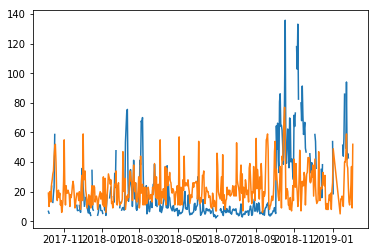

In [102]:
plt.plot(uba_ours)